# Paper: Towards JITAI -



In [1]:
import os
import sys
import regex as re
# If your current working directory is the notebooks directory, use this:
notebook_dir = os.getcwd()  # current working directory
src_path = os.path.abspath(os.path.join(notebook_dir, '..', 'src'))
parent_dir = os.path.abspath(os.path.join(notebook_dir, '..'))
model_path = os.path.abspath(os.path.join(notebook_dir, '..', 'model_pipeline'))

sys.path.append(parent_dir)
sys.path.append(src_path)
sys.path.append(model_path)

import glob
import pickle
from IPython.display import Markdown
from server_config import datapath, preprocessed_path, preprocessed_path_freezed, redcap_path

import pandas as pd
import numpy as np
import datetime as dt
from scipy.stats import entropy

from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder, FunctionTransformer
# Enable experimental features in scikit-learn
from sklearn.experimental import enable_iterative_imputer  # ✅ Must be imported first
from sklearn.impute import IterativeImputer  # ✅ Now you can import it


import ML_config
import ML_pipeline
import run_ML_pipeline

import matplotlib.pyplot as plt
from matplotlib import rcParams
import seaborn as sns 
import matplotlib.patches as mpatches

sns.set_context("notebook", rc={"axes.labelsize": 14, "xtick.labelsize": 14, "ytick.labelsize": 14})
sns.set_style("whitegrid", {'axes.grid': True})
%matplotlib inline
import plotly.express as px
import plotly.graph_objs as go
from plotly.subplots import make_subplots


2025-02-11 09:47:34.423255: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2025-02-11 09:47:34.426390: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2025-02-11 09:47:34.437194: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1739263654.455436 1345188 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1739263654.460959 1345188 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-02-11 09:47:34.478910: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU ins

In [2]:
#backup_path = preprocessed_path + "backup_data_passive.feather"
#df_backup = pd.read_feather(backup_path)

with open(preprocessed_path_freezed + '/ema_data.pkl', 'rb') as file:
    df_ema_framework = pickle.load(file)

with open(preprocessed_path_freezed + '/ema_content.pkl', 'rb') as file:
    df_ema_content = pickle.load(file)  

with open(preprocessed_path_freezed + '/monitoring_data.pkl', 'rb') as file:
    df_monitoring = pickle.load(file)

with open(preprocessed_path_freezed + '/redcap_data.pkl', 'rb') as file:
    df_redcap = pickle.load(file)

with open(preprocessed_path_freezed + '/map_ema_passive.pkl', 'rb') as file:
    df_ema_passive = pickle.load(file)

### Configurations

In [3]:
# EMA
assessment_phase = [0] #1,2
min_num_daily = 4
min_days_data = 7

### 3. Compare Included vs. not Included Participantants

In [4]:
df_ema_content_cust = df_ema_content.customer.unique().tolist()

In [5]:
df_redcap_original = df_redcap.dropna(subset = ["age", "customer"] )
df_redcap_original = df_redcap_original[df_redcap_original.customer.isin(df_ema_content_cust)]
df_redcap_original = df_redcap_original.drop_duplicates(subset="customer")


In [6]:
# Create a set of included customer IDs
included_customers = set(df_ema_passive['customer'])

# Add a new column to df_redcap_original indicating inclusion
df_redcap_original['Included'] = df_redcap_original['customer'].isin(included_customers)

# Define the two groups
df_redcap_original['Group'] = df_redcap_original['Included'].map({True: 'Included', False: 'Not Included'})

# Verify the counts
print(f"Subjects included in the analysis (n={df_redcap_original['Group'].value_counts().get('Included', 0)})")
print(f"Subjects not included in the analysis (n={df_redcap_original['Group'].value_counts().get('Not Included', 0)})")


Subjects included in the analysis (n=158)
Subjects not included in the analysis (n=143)


In [7]:
from tableone import TableOne
# Define your variables
# Replace the variable names with those present in your DataFrame

# Demographic variables
age = 'age'  # Continuous
employable = 'employability_description_simple'  # Categorical
smartphone_type = 'ema_smartphone_description'  # Categorical
psychotropic_med = 'psychotropic_description'
diagnosis = 'scid_cv_description'
previous_treatment = 'prior_treatment_description_simple'
somatic = 'somatic_description'



# List of all variables to include in the table
columns = [age, employable, smartphone_type, previous_treatment, psychotropic_med, diagnosis, somatic]

# Define categorical variables
categorical = [employable, smartphone_type, previous_treatment, psychotropic_med, diagnosis, somatic]

# Define grouping variable
group_var = 'Included'


In [8]:
# Create the TableOne object
table1 = TableOne(
    df_redcap_original,
    columns=columns,
    categorical=categorical,
    groupby=group_var,
    pval=True,
    nonnormal=[],  # Add variables that are non-normally distributed if any
    missing=False  # Whether to include missing data
)

# Print the table
print(table1.tabulate(tablefmt="fancy_grid"))
table1.to_csv('sample_overview.csv')


╒═══════════════════════════════════════════╤═══════════════════════════════════╤═════════════╤═════════════╤═════════════╤═══════════╕
│                                           │                                   │ Overall     │ False       │ True        │ P-Value   │
╞═══════════════════════════════════════════╪═══════════════════════════════════╪═════════════╪═════════════╪═════════════╪═══════════╡
│ n                                         │                                   │ 301         │ 143         │ 158         │           │
├───────────────────────────────────────────┼───────────────────────────────────┼─────────────┼─────────────┼─────────────┼───────────┤
│ age, mean (SD)                            │                                   │ 33.1 (10.9) │ 33.7 (11.5) │ 32.5 (10.2) │ 0.329     │
├───────────────────────────────────────────┼───────────────────────────────────┼─────────────┼─────────────┼─────────────┼───────────┤
│ employability_description_simple, n (%)   │ no

## Manual Missing data handling

In [9]:
# also impute activity features 

#### GPS

In [10]:
# Create a mask for rows where missing_GPS equals 'Steps<=625'
mask = df_ema_passive['missing_GPS'] == 'Steps<=625'

# For these rows, set the selected columns to 0
cols_set_zero = ['n_GPS', 'total_distance_km', 'time_in_transition_minutes']
for col in cols_set_zero:
    df_ema_passive.loc[mask, col] = 0

# For these rows, set the selected columns to 120
cols_set_120 = ['time_stationary_minutes']
for col in cols_set_120:
    df_ema_passive.loc[mask, col] = 120

mask = df_ema_passive['missing_GPS_home'] == 'Steps<=625'

# For these rows, set the selected columns to 120
cols_set_120 = ['at_home_minute']
for col in cols_set_120:
    df_ema_passive.loc[mask, col] = 120


#### Steps

In [11]:
# Create a mask for rows where missing_GPS equals 'Steps>625'
mask = df_ema_passive['missing_steps'] == 'step_zero'

# For these rows, set the selected columns to 0
cols_set_zero = ['n_steps']
for col in cols_set_zero:
    df_ema_passive.loc[mask, col] = 0

#### Physical Activity

In [12]:
# Create a mask for rows where missing_GPS equals 'Steps>625'
mask = df_ema_passive['missing_pa'] == 'pa_zero'

# For these rows, set the selected columns to 0
cols_set_zero = ['activity_102_minutes', 'activity_103_minutes', 'activity_104_minutes', 'activity_105_minutes', 'activity_106_minutes', 
                 'activity_107_minutes']
for col in cols_set_zero:
    df_ema_passive.loc[mask, col] = 0

### Feature Encoding

- prior treatment: ordinal encoding
- age: min-max scaling
- somatic, employability, psychotropic: 

In [13]:
# Define which columns are which
binary_features = ['somatic_description', 'psychotropic_description', 'employability_description_simple', 'smartphone_type', 'weekend']
categorical_features = ['weekday', 'prior_treatment_description_simple', 'quest_create_hour', 'season', 'time_of_day', 'employability_description_simple']
numeric_features = ['age','hr_mean', 'hr_min', 'hr_max', 'hr_std', 'hr_zone_resting', 'hr_zone_moderate','hr_zone_vigorous', 'n_steps', 
       'n_GPS', 'total_distance_km', 'at_home_minute',
       'time_in_transition_minutes', 'time_stationary_minutes', 'activity_102_minutes',
       'activity_103_minutes', 'activity_104_minutes', 'activity_105_minutes',
       'activity_106_minutes', 'activity_107_minutes',
       'apparent_temperature_mean', 'sunshine_duration', 'precipitation_hours'] 

person_static_features = ['customer', 'age', 'somatic_description', 'psychotropic_description', 'employability_description_simple', 'smartphone_type', 'weekend']


In [14]:
categories = [sorted(df_ema_passive[feat].dropna().unique()) for feat in categorical_features]


In [15]:
df_ema_passive[numeric_features] = df_ema_passive[numeric_features].replace(-1, np.nan)

In [16]:
from scipy.stats import skewtest,normaltest

skewed_features = []
for col in numeric_features:
    valid_data = df_ema_passive[col].dropna()

    # skewtest requires sample size > 7 for reliable results
    stat, p_val = skewtest(valid_data)
    if p_val < 0.05:
        skewed_features.append(col)  # append this feature as skewed


### Model Pipeline

In [17]:
df_ema_passive["intercept"] = 1

In [18]:
df_ema_pipeline = df_ema_passive[['customer', 'unique_day_id', 
       'quest_create_hour', 'weekday', 'weekend', 'season', 'time_of_day',
       'n_quest', 'mean_na', 'sensor_block_end', 'age', 
       'ema_smartphone', 'psychotropic', 'somatic_problems','employability_description_simple',
       'prior_treatment_description_simple',
       'hr_mean', 'hr_min', 'hr_max', 'hr_std', 
       'hr_zone_resting', 'hr_zone_moderate',
       'hr_zone_vigorous', 'n_steps',  'n_GPS', 'total_distance_km', 'at_home_minute',
       'time_in_transition_minutes', 'time_stationary_minutes',
       'activity_102_minutes',
       'activity_103_minutes', 'activity_104_minutes', 'activity_105_minutes',
       'activity_106_minutes', 'activity_107_minutes',
       'apparent_temperature_mean', 'sunshine_duration', 'precipitation_hours', 'intercept'
      ]]

In [19]:
df_ema_passive['customer'] = df_ema_passive['customer'].astype('string')
df_ema_passive.to_csv("short_term_data.csv")

In [20]:
for col in numeric_features:
    series = df_ema_pipeline[col]
    n_nan = series.isna().sum()
    col_min = series.min()
    col_max = series.max()
    col_mean = series.mean()
    col_std = series.std()
    print(f"{col}: NaNs={n_nan}, min={col_min}, max={col_max}, mean={col_mean}, std={col_std}")


age: NaNs=0, min=18.0, max=66.0, mean=32.22805878054721, std=9.986262010627621
hr_mean: NaNs=362, min=40.583333333333336, max=176.0, mean=76.21038364205769, std=14.42543554669274
hr_min: NaNs=362, min=35.0, max=176.0, mean=61.30263488080301, std=11.62405021207671
hr_max: NaNs=362, min=42.0, max=211.0, mean=96.8409870347135, std=27.542694611533477
hr_std: NaNs=362, min=0.0, max=56.0, mean=10.792436474020727, std=7.9558771372936725
hr_zone_resting: NaNs=362, min=0.0, max=32.400000000000006, mean=1.3624361661787256, std=2.2104999178041633
hr_zone_moderate: NaNs=362, min=0.0, max=114.00951666666391, mean=5.550823878433013, std=3.4077147994985237
hr_zone_vigorous: NaNs=362, min=0.0, max=78.6040666666656, mean=1.0310447901854172, std=3.6420108564005598
n_steps: NaNs=198, min=0.0, max=10078.0, mean=842.1961382952388, std=1105.3486861640363
n_GPS: NaNs=880, min=0.0, max=1897.0, mean=45.22707003584856, std=113.742096612119
total_distance_km: NaNs=880, min=0.0, max=180.0840241629681, mean=2.4437

In [21]:
df_ema_pipeline["n_quest_sum"] = (df_ema_pipeline.groupby('customer')['unique_day_id'].transform('nunique')
)

/tmp/ipykernel_1345188/728832176.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_ema_pipeline["n_quest_sum"] = (df_ema_pipeline.groupby('customer')['unique_day_id'].transform('nunique')


In [22]:
df_ema_strat = df_ema_pipeline[["customer", "n_quest_sum"]].drop_duplicates()
df_ema_strat['n_quest_stratify'] = pd.qcut(df_ema_strat["n_quest_sum"], q=4, labels=False, duplicates="drop")


In [23]:
df_ema_pipeline= pd.merge(df_ema_pipeline,df_ema_strat, on=["customer", "n_quest_sum"], how="left")

In [45]:
import plotly.graph_objects as go
from plotly.subplots import make_subplots

# Assume df_ema_pipeline is your DataFrame with columns "customer" and "mean_na"
# Compute individual mean outcomes.
grouped = df_ema_pipeline.groupby("customer")["mean_na"]
individual_means = grouped.mean()
overall_mean = individual_means.mean()

In [26]:
from ML_pipeline import MLpipeline
from ML_config import Config

my_config = Config()
pipeline = MLpipeline(my_config)

pipeline.set_data(df_ema_pipeline)
pipeline.outer_user_split()
pipeline.inner_time_split()

# (1) Time-based runs
results_timebased, results_holdout = pipeline.run(my_config.ANALYSIS["neg_affect_regression"]["MODEL_PIPEGRIDS"])


INFO     [ML_pipeline.py:203] [ML_Pipeline] Configuration Loaded:
INFO     [ML_pipeline.py:204]   Impute Strategy: knn
INFO     [ML_pipeline.py:205]   Scaler Strategy: minmax
INFO     [ML_pipeline.py:206]   Holdout Ratio: 0.1
INFO     [ML_pipeline.py:207]   Time Ratio: 0.8
INFO     [ML_pipeline.py:208]   Number of Jobs: 1
INFO     [ML_pipeline.py:209]   Number of Folds (Inner CV): 5
INFO     [ML_pipeline.py:210]   CV Method: forwardchaining (expected 'forwardchaining' here)
INFO     [ML_pipeline.py:218] [set_data] DataFrame with 12317 rows loaded in pipeline.
INFO     [ML_pipeline.py:289] [outer_user_split] Holdout Users: 15/158 | Holdout Strategy: first_20 | Holdout Size: 224 rows.
INFO     [ML_pipeline.py:315] [inner_time_split] Inner train size: 8880, test size: 2290.
INFO     [ML_pipeline.py:525] [run] Starting the ML pipeline run method.
INFO     [ML_pipeline.py:549] 
[run] Starting pipeline: Global_Intercept


features: ['at_home_minute', 'activity_104_minutes', 'time_of_day', 'time_stationary_minutes', 'hr_max', 'hr_mean', 'activity_103_minutes', 'sunshine_duration', 'quest_create_hour', 'hr_zone_moderate', 'precipitation_hours', 'hr_zone_vigorous', 'activity_106_minutes', 'n_GPS', 'weekend', 'time_in_transition_minutes', 'hr_std', 'weekday', 'apparent_temperature_mean', 'hr_min', 'hr_zone_resting', 'season', 'activity_105_minutes', 'n_steps', 'activity_102_minutes', 'activity_107_minutes', 'total_distance_km']


INFO     [ML_pipeline.py:575] [Global_Intercept] Fitting GridSearchCV.
INFO     [ML_pipeline.py:119] [PerUserForwardChainingCV] Unique users found: 143
INFO     [ML_pipeline.py:577] [Global_Intercept] GridSearchCV completed.
INFO     [ML_pipeline.py:578] [Global_Intercept] Best Parameters: {}
INFO     [ML_pipeline.py:579] [Global_Intercept] Best CV Score (mae): 0.883
INFO     [ML_pipeline.py:614] [Global_Intercept] Inner Test Scores: {'r2': -0.009145076570804545, 'mae': 0.9735838472205831, 'rmse': 1.1884263092171299}
INFO     [ML_pipeline.py:549] 
[run] Starting pipeline: PerUser_Intercept


features: ['at_home_minute', 'customer', 'activity_104_minutes', 'time_of_day', 'time_stationary_minutes', 'hr_max', 'hr_mean', 'activity_103_minutes', 'sunshine_duration', 'quest_create_hour', 'hr_zone_moderate', 'precipitation_hours', 'hr_zone_vigorous', 'activity_106_minutes', 'n_GPS', 'weekend', 'time_in_transition_minutes', 'hr_std', 'weekday', 'apparent_temperature_mean', 'hr_min', 'hr_zone_resting', 'season', 'activity_105_minutes', 'n_steps', 'activity_102_minutes', 'activity_107_minutes', 'total_distance_km']


INFO     [ML_pipeline.py:575] [PerUser_Intercept] Fitting GridSearchCV.
INFO     [ML_pipeline.py:119] [PerUserForwardChainingCV] Unique users found: 143


✅ Fit completed. Detected 143 unique users.
✅ Fit completed. Detected 143 unique users.
✅ Fit completed. Detected 143 unique users.
✅ Fit completed. Detected 143 unique users.


INFO     [ML_pipeline.py:577] [PerUser_Intercept] GridSearchCV completed.
INFO     [ML_pipeline.py:578] [PerUser_Intercept] Best Parameters: {}
INFO     [ML_pipeline.py:579] [PerUser_Intercept] Best CV Score (mae): 0.600


✅ Fit completed. Detected 143 unique users.


INFO     [ML_pipeline.py:614] [PerUser_Intercept] Inner Test Scores: {'r2': 0.5216969745545884, 'mae': 0.6124634527085445, 'rmse': 0.8181765326969993}
INFO     [ML_pipeline.py:549] 
[run] Starting pipeline: LR_nonscaled


features: ['at_home_minute', 'activity_104_minutes', 'time_of_day', 'time_stationary_minutes', 'hr_max', 'hr_mean', 'activity_103_minutes', 'sunshine_duration', 'quest_create_hour', 'hr_zone_moderate', 'precipitation_hours', 'hr_zone_vigorous', 'activity_106_minutes', 'n_GPS', 'weekend', 'time_in_transition_minutes', 'hr_std', 'weekday', 'apparent_temperature_mean', 'hr_min', 'hr_zone_resting', 'season', 'activity_105_minutes', 'n_steps', 'activity_102_minutes', 'activity_107_minutes', 'total_distance_km']


INFO     [ML_pipeline.py:575] [LR_nonscaled] Fitting GridSearchCV.
INFO     [ML_pipeline.py:119] [PerUserForwardChainingCV] Unique users found: 143
INFO     [ML_pipeline.py:577] [LR_nonscaled] GridSearchCV completed.
INFO     [ML_pipeline.py:578] [LR_nonscaled] Best Parameters: {'model_LR__fit_intercept': True}
INFO     [ML_pipeline.py:579] [LR_nonscaled] Best CV Score (mae): 172651060.482
INFO     [ML_pipeline.py:614] [LR_nonscaled] Inner Test Scores: {'r2': 0.00936318417328319, 'mae': 0.9638098570977757, 'rmse': 1.177477688768285}
INFO     [ML_pipeline.py:549] 
[run] Starting pipeline: LR_with_PS_nonscaled


features: ['psychotropic', 'at_home_minute', 'activity_104_minutes', 'time_of_day', 'ema_smartphone', 'time_stationary_minutes', 'hr_max', 'somatic_problems', 'hr_mean', 'activity_103_minutes', 'sunshine_duration', 'quest_create_hour', 'hr_zone_moderate', 'precipitation_hours', 'hr_zone_vigorous', 'activity_106_minutes', 'n_GPS', 'weekend', 'prior_treatment_description_simple', 'time_in_transition_minutes', 'hr_std', 'weekday', 'apparent_temperature_mean', 'hr_min', 'age', 'hr_zone_resting', 'season', 'employability_description_simple', 'activity_105_minutes', 'n_steps', 'activity_102_minutes', 'activity_107_minutes', 'total_distance_km']


INFO     [ML_pipeline.py:575] [LR_with_PS_nonscaled] Fitting GridSearchCV.
INFO     [ML_pipeline.py:119] [PerUserForwardChainingCV] Unique users found: 143
INFO     [ML_pipeline.py:577] [LR_with_PS_nonscaled] GridSearchCV completed.
INFO     [ML_pipeline.py:578] [LR_with_PS_nonscaled] Best Parameters: {'model_LRPS__fit_intercept': True}
INFO     [ML_pipeline.py:579] [LR_with_PS_nonscaled] Best CV Score (mae): 290660022.276
INFO     [ML_pipeline.py:614] [LR_with_PS_nonscaled] Inner Test Scores: {'r2': 0.04814605124518212, 'mae': 0.9430553186408297, 'rmse': 1.1541987847082693}
INFO     [ML_pipeline.py:549] 
[run] Starting pipeline: RF_nonscaled


features: ['at_home_minute', 'activity_104_minutes', 'time_of_day', 'time_stationary_minutes', 'hr_max', 'hr_mean', 'activity_103_minutes', 'sunshine_duration', 'quest_create_hour', 'hr_zone_moderate', 'precipitation_hours', 'hr_zone_vigorous', 'activity_106_minutes', 'n_GPS', 'weekend', 'time_in_transition_minutes', 'hr_std', 'weekday', 'apparent_temperature_mean', 'hr_min', 'hr_zone_resting', 'season', 'activity_105_minutes', 'n_steps', 'activity_102_minutes', 'activity_107_minutes', 'total_distance_km']


INFO     [ML_pipeline.py:575] [RF_nonscaled] Fitting GridSearchCV.
INFO     [ML_pipeline.py:119] [PerUserForwardChainingCV] Unique users found: 143
INFO     [ML_pipeline.py:577] [RF_nonscaled] GridSearchCV completed.
INFO     [ML_pipeline.py:578] [RF_nonscaled] Best Parameters: {'model_TTR__regressor__max_depth': 20, 'model_TTR__regressor__max_features': 'log2', 'model_TTR__regressor__min_samples_split': 2, 'model_TTR__regressor__n_estimators': 100}
INFO     [ML_pipeline.py:579] [RF_nonscaled] Best CV Score (mae): 0.874
INFO     [ML_pipeline.py:614] [RF_nonscaled] Inner Test Scores: {'r2': 0.04528665328110304, 'mae': 0.941336394893133, 'rmse': 1.155931108671876}
INFO     [ML_pipeline.py:549] 
[run] Starting pipeline: RF_with_PS_nonscaled


features: ['psychotropic', 'at_home_minute', 'activity_104_minutes', 'time_of_day', 'ema_smartphone', 'time_stationary_minutes', 'hr_max', 'somatic_problems', 'hr_mean', 'activity_103_minutes', 'sunshine_duration', 'quest_create_hour', 'hr_zone_moderate', 'precipitation_hours', 'hr_zone_vigorous', 'activity_106_minutes', 'n_GPS', 'weekend', 'prior_treatment_description_simple', 'time_in_transition_minutes', 'hr_std', 'weekday', 'apparent_temperature_mean', 'hr_min', 'age', 'hr_zone_resting', 'season', 'employability_description_simple', 'activity_105_minutes', 'n_steps', 'activity_102_minutes', 'activity_107_minutes', 'total_distance_km']


INFO     [ML_pipeline.py:575] [RF_with_PS_nonscaled] Fitting GridSearchCV.
INFO     [ML_pipeline.py:119] [PerUserForwardChainingCV] Unique users found: 143
INFO     [ML_pipeline.py:577] [RF_with_PS_nonscaled] GridSearchCV completed.
INFO     [ML_pipeline.py:578] [RF_with_PS_nonscaled] Best Parameters: {'model_TTR__regressor__max_depth': 10, 'model_TTR__regressor__max_features': 'log2', 'model_TTR__regressor__min_samples_split': 5, 'model_TTR__regressor__n_estimators': 100}
INFO     [ML_pipeline.py:579] [RF_with_PS_nonscaled] Best CV Score (mae): 0.829
INFO     [ML_pipeline.py:614] [RF_with_PS_nonscaled] Inner Test Scores: {'r2': 0.14952011635810092, 'mae': 0.8917001324111177, 'rmse': 1.0910068505980433}
INFO     [ML_pipeline.py:549] 
[run] Starting pipeline: FFNN_nonscaled


features: ['at_home_minute', 'activity_104_minutes', 'time_of_day', 'time_stationary_minutes', 'hr_max', 'hr_mean', 'activity_103_minutes', 'sunshine_duration', 'quest_create_hour', 'hr_zone_moderate', 'precipitation_hours', 'hr_zone_vigorous', 'activity_106_minutes', 'n_GPS', 'weekend', 'time_in_transition_minutes', 'hr_std', 'weekday', 'apparent_temperature_mean', 'hr_min', 'hr_zone_resting', 'season', 'activity_105_minutes', 'n_steps', 'activity_102_minutes', 'activity_107_minutes', 'total_distance_km']


INFO     [ML_pipeline.py:575] [FFNN_nonscaled] Fitting GridSearchCV.
INFO     [ML_pipeline.py:119] [PerUserForwardChainingCV] Unique users found: 143
2025-02-11 10:01:15.547942: E external/local_xla/xla/stream_executor/cuda/cuda_driver.cc:152] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: UNKNOWN ERROR (303)
INFO     [ML_pipeline.py:577] [FFNN_nonscaled] GridSearchCV completed.
INFO     [ML_pipeline.py:578] [FFNN_nonscaled] Best Parameters: {'keras_model__regressor__batch_size': 64, 'keras_model__regressor__dropout_rate': 0.5, 'keras_model__regressor__hidden_units': (64, 32), 'keras_model__regressor__learning_rate': 0.0001}
INFO     [ML_pipeline.py:579] [FFNN_nonscaled] Best CV Score (mae): 1.908
INFO     [ML_pipeline.py:614] [FFNN_nonscaled] Inner Test Scores: {'r2': -0.4353008554943314, 'mae': 1.1279732746328328, 'rmse': 1.4173167725084688}
INFO     [ML_pipeline.py:549] 
[run] Starting pipeline: FFNN_with_PS_nonscaled


features: ['psychotropic', 'at_home_minute', 'activity_104_minutes', 'time_of_day', 'ema_smartphone', 'time_stationary_minutes', 'hr_max', 'somatic_problems', 'hr_mean', 'activity_103_minutes', 'sunshine_duration', 'quest_create_hour', 'hr_zone_moderate', 'precipitation_hours', 'hr_zone_vigorous', 'activity_106_minutes', 'n_GPS', 'weekend', 'prior_treatment_description_simple', 'time_in_transition_minutes', 'hr_std', 'weekday', 'apparent_temperature_mean', 'hr_min', 'age', 'hr_zone_resting', 'season', 'employability_description_simple', 'activity_105_minutes', 'n_steps', 'activity_102_minutes', 'activity_107_minutes', 'total_distance_km']


INFO     [ML_pipeline.py:575] [FFNN_with_PS_nonscaled] Fitting GridSearchCV.
INFO     [ML_pipeline.py:119] [PerUserForwardChainingCV] Unique users found: 143


KeyboardInterrupt: 

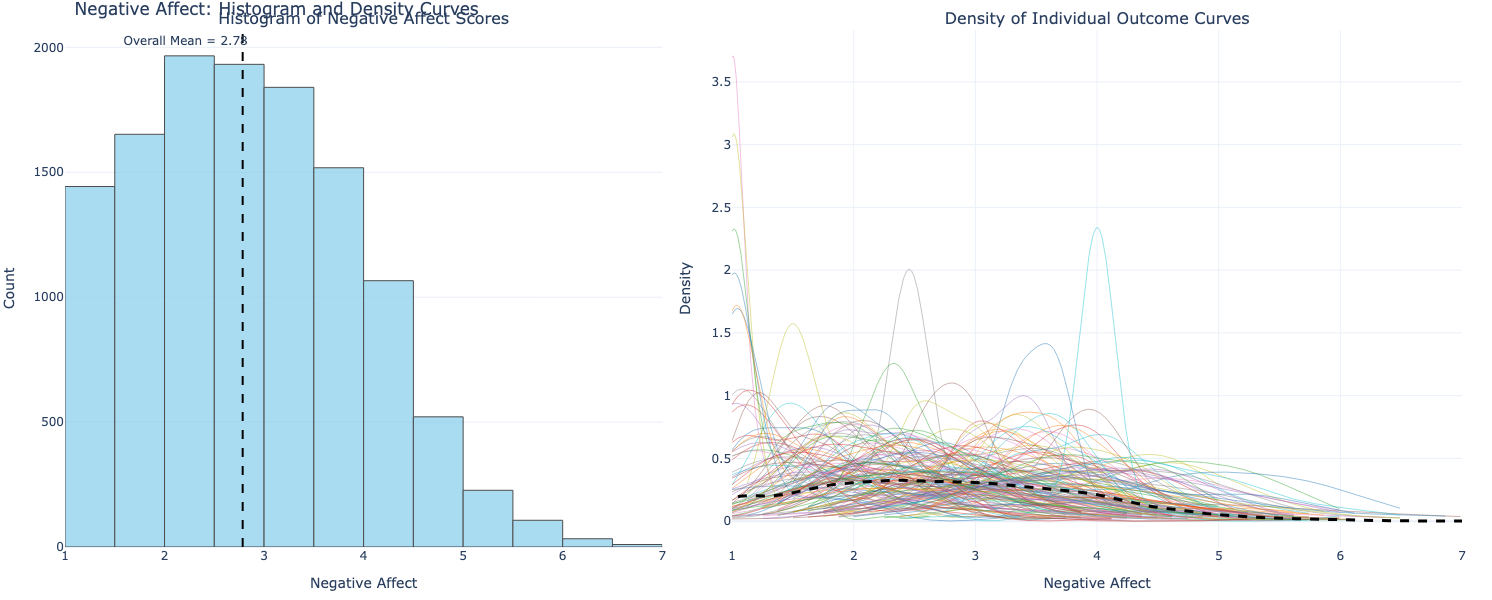

<Figure size 640x480 with 0 Axes>

In [62]:
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import plotly.figure_factory as ff
import numpy as np
import pandas as pd
import seaborn as sns
from scipy.stats import gaussian_kde

# Assume df_ema_pipeline is your DataFrame with columns "customer" and "mean_na"
# and that negative affect scores range between 1 and 7.

# ---------------------------
# LEFT PANEL: Histogram of all raw negative affect scores
# ---------------------------
all_scores = df_ema_pipeline["mean_na"].values
overall_mean_all = np.mean(all_scores)
nbins = 20

# ---------------------------
# RIGHT PANEL: Density Plot of Individual Outcome Curves
# ---------------------------
data = []
group_labels = []
for customer, group in df_ema_pipeline.groupby("customer"):
    if len(group["mean_na"]) > 1:
        data.append(group["mean_na"].values)
        group_labels.append(str(customer))
        
# Create the individual density curves using Plotly's figure factory.
ff_fig = ff.create_distplot(data, group_labels, show_hist=False, show_rug=False)
ff_fig.update_traces(opacity=0.45, line=dict(width=1))
# Compute overall density using seaborn for all outcome values.
overall_kde_plot = sns.kdeplot(df_ema_pipeline["mean_na"], bw_adjust=1, fill=False)
lines = overall_kde_plot.get_lines()
x_overall_ff, y_overall_ff = lines[0].get_data()
overall_kde_plot.figure.clf()  # Clear the temporary seaborn figure.
# Add overall density as a dashed black line.
ff_fig.add_trace({
    "type": "scatter",
    "x": x_overall_ff,
    "y": y_overall_ff,
    "mode": "lines",
    "line": {"color": "black", "width": 3, "dash": "dash"},
    "name": "Overall Density"
})

# ---------------------------
# Create Subplots: 1 row, 2 columns
# Use column_widths to make the right panel a bit wider.
# Set horizontal_spacing to a small value.
fig = make_subplots(
    rows=1, cols=2,
    subplot_titles=("Histogram of Negative Affect Scores", "Density of Individual Outcome Curves"),
    column_widths=[0.45, 0.55],
    horizontal_spacing=0.05
)

# LEFT PANEL: Add histogram trace.
fig.add_trace(go.Histogram(
    x=all_scores,
    nbinsx=nbins,
    name="Negative Affect",
    marker_color="skyblue",
    opacity=0.7,
    marker_line_color="black",  # thin black borders
    marker_line_width=1
), row=1, col=1)

# Add vertical dashed line for overall mean in the left panel.
fig.add_vline(
    x=overall_mean_all,
    line=dict(color='black', dash='dash'),
    annotation_text=f"Overall Mean = {overall_mean_all:.2f}",
    annotation_position="top left",
    row=1, col=1
)

# RIGHT PANEL: Add all traces from the figure factory (density curves).
for trace in ff_fig.data:
    fig.add_trace(trace, row=1, col=2)

# ---------------------------
# Update Axes and Layout
# ---------------------------
# Set x-axis range for both panels.
fig.update_xaxes(title_text="Negative Affect", range=[1, 7], row=1, col=1)
fig.update_xaxes(title_text="Negative Affect", range=[1, 7], row=1, col=2)
# Set y-axis titles.
fig.update_yaxes(title_text="Count", row=1, col=1)
fig.update_yaxes(title_text="Density", row=1, col=2)

# Force both subplots to share the same vertical domain to align them.
fig.update_yaxes(domain=[0, 1], row=1, col=1)
fig.update_yaxes(domain=[0, 1], row=1, col=2)

# Update overall layout.
fig.update_layout(
    title_text="Negative Affect: Histogram and Density Curves",
    width=1000,
    height=600,
    showlegend=False,
    plot_bgcolor="white",
    paper_bgcolor="white",
    margin=dict(l=30, r=30, t=30, b=30),
    template="plotly_white"
)

fig.show()


In [ ]:
import pandas as pd

def format_results_as_dataframe(results_timebased, holdout_results):
    """
    Formats the results into a structured DataFrame with columns:
    - pipeline_name
    - best_cv_score
    - r2, mae, rmse (inner test scores)
    - holdout_r2, holdout_mae, holdout_rmse (holdout test scores)
    - hyperparameters (only relevant hyperparameters per model)

    Parameters:
    ----------
    results_timebased : list
        List of dictionaries containing results from ML pipelines.
    holdout_results : list
        List of dictionaries containing holdout evaluation results.

    Returns:
    -------
    pd.DataFrame
        A DataFrame displaying structured results.
    """

    formatted_results = []

    # Create a mapping of pipeline_name -> holdout_scores for easy lookup
    holdout_scores_map = {res["pipeline_name"]: res["holdout_scores"] for res in holdout_results}

    for result in results_timebased:
        pipeline_name = result["pipeline_name"]
        best_cv_score = result["best_cv_score"]
        
        # Extract inner test scores
        inner_test_scores = result["inner_test_scores"]
        r2 = inner_test_scores.get("r2", None)
        mae = inner_test_scores.get("mae", None)
        rmse = inner_test_scores.get("rmse", None)
        
        # Extract holdout scores if available
        holdout_scores = holdout_scores_map.get(pipeline_name, {})
        holdout_r2 = holdout_scores.get("r2", None)
        holdout_mae = holdout_scores.get("mae", None)
        holdout_rmse = holdout_scores.get("rmse", None)

        # Extract relevant hyperparameters dynamically
        best_estimator = result["best_estimator"]
        hyperparameters = {}

        if hasattr(best_estimator, 'get_params'):
            params = best_estimator.get_params()
            
            # Select relevant hyperparameters based on known model prefixes
            param_keys = [
                "model_LR__fit_intercept",
                "model_LRPS__fit_intercept",
                "model_TTR__regressor__n_estimators",
                "model_TTR__regressor__max_depth",
                "model_TTR__regressor__min_samples_split",
                "model_TTR__regressor__max_features",
                "model_MERF__regressor__max_iterations",
                "model_MERF__regressor__rf__n_estimators",
                "model_TTR__regressor__hidden_layer_sizes",
                "model_TTR__regressor__alpha"
            ]

            # Extract only relevant hyperparameters for the current model
            for key in param_keys:
                if key in params:
                    hyperparameters[key] = params[key]

        formatted_results.append({
            "pipeline_name": pipeline_name,
            "best_cv_score": best_cv_score,
            "r2": r2,
            "mae": mae,
            "rmse": rmse,
            "holdout_r2": holdout_r2,
            "holdout_mae": holdout_mae,
            "holdout_rmse": holdout_rmse,
            "hyperparameters": hyperparameters  # Store extracted hyperparameters
        })

    df_results = pd.DataFrame(formatted_results)
    return df_results


In [ ]:
df_results = format_results_as_dataframe(results_timebased, results_holdout)


In [ ]:
df_results